## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions import *
from sklearn.preprocessing import OneHotEncoder
from tqdm.notebook import tqdm
from IPython.display import clear_output
%matplotlib inline



## My network
from NN import *

# THE NETWORK DEFINITION 

In [ ]:
class Network():
    def __init__(self,layers = []):
        self.layers = layers[:]
        self.startup()
        
    def add(self,layer):
        self.layers.append(layer)
    
    def startup(self,n_epochs=40, n_batch=100, eta=0.001, reg=0.01, eta_min=None, eta_max=None, n_s=None):
        # Main param
        self.n_batch = n_batch
        self.eta = eta # learning rate
        self.reg = reg # regularization of weights
        
        ## Cyclic learning rate
        self.eta_min = eta_min
        self.eta_max = eta_max
        self.n_s = n_s
        self.t = 0 # nr of updates
        
        ## Logging
        self.train_acc_log = []
        self.val_acc_log = []
        self.train_loss_log = []
        self.val_loss_log = []
        self.train_cost_log = []
        self.val_cost_log = []
        self.eta_log = []
        self.t = 0
        
    def re_init(self):
        for l in self.layers:
            if l.fc:
                l.__init__(l.ins,l.outs)
                
    #############################################    
    ######## Cross Entropy loss function ########    
    def CrossEntropyLoss(self, softmax_input, P, Y_batch):
        lossgrad = -(Y_batch - P)
        tmp = np.exp(softmax_input)
        return lossgrad
    
    def SoftMax(self, input):
        tmp = np.exp(input)
        softmax = tmp / np.sum(tmp,0)[np.newaxis,:]
        return softmax
       
    def loss(self,X_batch, Y_batch):              
        activations = self.forward(X_batch)
        softmax_input = activations[-1]
        tmp = np.exp(softmax_input)
        loss_matrix = - softmax_input + np.log(np.sum(tmp,0))[np.newaxis,:]
        return (loss_matrix * Y_batch).sum()/Y_batch.shape[1]
    #############################################
    
    
    #############################################    
    ########           Logging           ########                  
    def logging(self, X_train, Y_train_hot, X_valid, Y_valid_hot, visualize, epoch):
        ll = 0
        for l in self.layers:
            if l.fc:
                ll +=self.reg*np.sum(l.weights[:]**2)
        self.train_acc_log.append(self.accuracy(X_train, Y_train_hot))
        self.val_acc_log.append(self.accuracy(X_valid, Y_valid_hot))
        self.train_loss_log.append(self.loss(X_train,Y_train_hot))
        self.val_loss_log.append(self.loss(X_valid,Y_valid_hot))
        self.train_cost_log.append(self.train_loss_log[-1] + ll)
        self.val_cost_log.append(self.val_loss_log[-1] + ll)
        if visualize:
            clear_output(wait="True")
        print("Epoch",epoch)
        print("Train accuracy:", self.train_acc_log[-1],"Train loss:","%.4f" % self.train_loss_log[-1] )
        print("Val accuracy:", self.val_acc_log[-1], "Val loss:", "%.4f" % self.val_loss_log[-1],"\n")
        if visualize:
            self.plot_training()
                
    def plot_training(self):
        fig, axs = plt.subplots(1,3, figsize=(15, 4))
        fig.subplots_adjust(hspace = .5, wspace=0.3)
        axs = axs.ravel()


        axs[0].plot(self.train_cost_log,label='train cost')
        axs[0].plot(self.val_cost_log,label='val cost')
        axs[0].legend(loc='best')
        axs[0].grid()
        
        axs[1].plot(self.train_loss_log,label='train loss')
        axs[1].plot(self.val_loss_log,label='val loss')
        axs[1].legend(loc='best')
        axs[1].grid()

        axs[2].plot(self.train_acc_log,label='train accuracy')
        axs[2].plot(self.val_acc_log,label='val accuracy')
        axs[2].legend(loc='best')
        axs[2].grid()
        plt.show()
    #############################################
    
    def forward(self, input):
        tmp = input
        activations = []
        activations.append(tmp)
        for l in self.layers:
            tmp = l.forward(activations[-1])
            activations.append(tmp)
        return activations
    
    def backward(self, X_batch, Y_batch):
        if Y_batch.ndim == 1:
            Y_batch = Y_batch.reshape(Y_batch.shape[0],1)
        activations = self.forward(X_batch)
        lossgrad = self.CrossEntropyLoss(activations[-1], self.SoftMax(activations[-1]), Y_batch)
        
        for i, l in reversed(list(enumerate(self.layers))):
            if l.fc:
                lossgrad = l.backward(activations[i], lossgrad, self.eta, self.reg)
            else:
                lossgrad = l.backward(activations[i],lossgrad)
    
    def predict(self, input):
        p = self.SoftMax(self.forward(input)[-1])
        return p.argmax(0)
    
    def accuracy(self, X, Y):
        Y_pred = self.predict(X)
        if Y.ndim == 2:
            Y = Y.argmax(0)
        return np.mean(Y_pred == Y)
    
    def cyclical_learning_rate(self):
        if self.eta_min and self.eta_max and self.n_s:
            t = np.mod(self.t, 2*self.n_s)
            self.eta = self.eta_min + np.copysign(np.mod(t,self.n_s),self.n_s-t)*(self.eta_max- self.eta_min)/self.n_s + (self.n_s<=t)*(self.eta_max-self.eta_min)
            self.eta_log.append(self.eta)

    def minibatch_SGD(self, X_train, Y_train_hot):
        n = X_train.shape[1]
        for j in range(0,n, self.n_batch):
                    self.cyclical_learning_rate() # updates the learning rate
                    X_batch = X_train[:, j:j+self.n_batch];
                    Y_batch = Y_train_hot[:, j:j+self.n_batch];
                    loss = self.backward(X_batch, Y_batch)
                    #self.t = np.mod(self.t+1, 2*self.n_s) # increase update nr
                    self.t += 1

    def augment_batch(self, X_batch,std = 0.1):
        return X_batch + np.random.normal(scale = std, size=X_batch.shape) # variance = std^2
    
    def train(self, X_train, Y_train_hot, X_valid, Y_valid_hot, 
              shufle=True, n_epochs=40, n_batch=100, eta=0.001, reg=0.01, visualize=False, 
              eta_min=None, eta_max=None, n_s=None, augment = False, ensamble = True, ensamble_list=None, ensamble_name ="ensamble"):
        
        # Delete old logging
        self.startup(n_epochs, n_batch, eta, reg, eta_min, eta_max, n_s)
        
        # Reiinit weighs
        self.re_init()
        
        for epoch in tqdm(range(n_epochs)):
            if shufle:
                X_train, Y_train_hot = shuffle(X_train,Y_train_hot) # shuffle

            ## Minibatch SGD
            self.minibatch_SGD(X_train, Y_train_hot)
            
            ## Logging
            self.logging(X_train, Y_train_hot, X_valid, Y_valid_hot, visualize,epoch+1)
            
            ## Ensamble
            if ensamble_list is not None:
                if epoch+1 in ensamble_list:
                    print("Save NN for ensamble in epoch:",epoch+1)
                    pickle.dump(self, open("Networks/"+ensamble_name+str(epoch+1)+".p", "wb"))
                    
                    
                    
# ===========================================================================#
def ensamble_prediction(nns,XX,YY):
    prediction_list = [nn.predict(XX) for nn in nns]
    tt = one_hot(10,prediction_list).transpose(1,2,0)
    aa = np.sum(tt,axis=0)
    ans = np.argmax(aa,1)
    if YY.ndim == 2:
        YY = list(YY.argmax(0))
        acc = np.mean(ans == YY[:])
    return acc

# Load dataset

In [2]:
X,Y=load_all_and_preproc()
Y = one_hot(10,Y)
X, Y, X_val, Y_val = create_val_set(X,Y)

print(X.shape,Y.shape, X_val.shape, Y_val.shape)


# Test
X_test,Y_test,filenames_test = LoadBatch('test_batch')
Y_test_hot = one_hot(10,Y_test)
X_test=preprocess(X_test)

(3072, 45000) (10, 45000) (3072, 5000) (10, 5000)


# IMPROVEMENTS

## 4) More hidden nodes

Epoch 11
Train accuracy: 0.6152888888888889 Train loss: 1.1123
Val accuracy: 0.5294 Val loss: 1.3706 



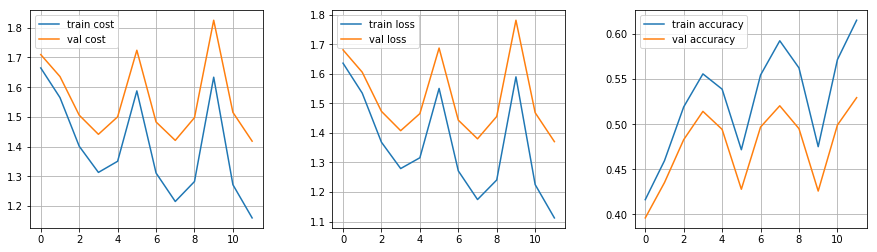


Train set accuracy: 0.6152888888888889
Validation set accuracy: 0.5294


In [4]:
# Parameters
n_in, n = X.shape
n_out = 10
n_hidden = 50

n_s = 900
n_batch=100
n_epochs = int(2*n_s*n_batch/n) * 3 


## Network
nn = Network()
nn.add(Dense(n_in, n_hidden))
nn.add(ReLU())
nn.add(Dense(n_hidden, n_out))


# Train
nn.train(X, Y, X_val, Y_val, 
         shufle = True, n_epochs=n_epochs, eta=0.001, reg = 0.000470, visualize=True, 
         eta_min=1e-5, eta_max=1e-1,n_s=900, augment = False)

# Evaluate
print("Train set accuracy:",nn.accuracy(X,Y))
print("Validation set accuracy:",nn.accuracy(X_val,Y_val))
#print("Test set accuracy:",nn.accuracy(X_test,Y_test_hot))

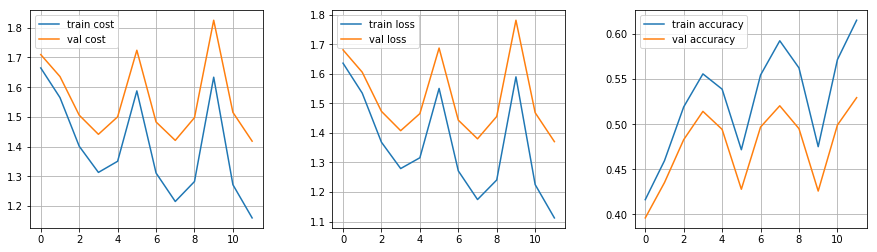

Train set accuracy: 0.6152888888888889
Validation set accuracy: 0.5294
Test set accuracy: 0.5186


In [5]:
# Save a dictionary into a pickle file.
import pickle


#pickle.dump( nn, open( "Networks/NN_more_hidden_nodes_12ep.p", "wb" ) )

nn = pickle.load( open("Networks/NN_more_hidden_nodes_12ep.p", "rb" ) )

nn.plot_training()
print("Train set accuracy:",nn.accuracy(X,Y))
print("Validation set accuracy:",nn.accuracy(X_val,Y_val))
print("Test set accuracy:",nn.accuracy(X_test,Y_test_hot))

## 5) Training data augmentation

Epoch 11
Train accuracy: 0.6105555555555555 Train loss: 1.1231
Val accuracy: 0.5274 Val loss: 1.3750 



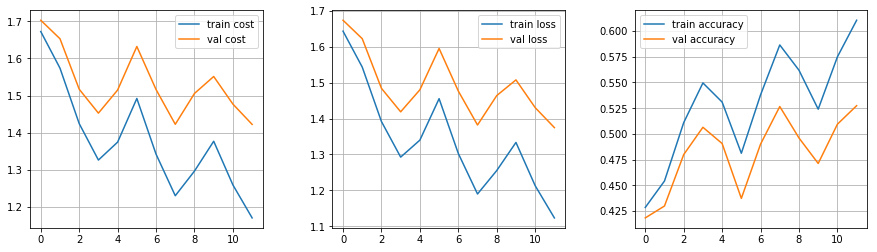


Train set accuracy: 0.6105555555555555
Validation set accuracy: 0.5274


In [10]:
# Parameters
n_in, n = X.shape
n_out = 10
n_hidden = 50
n_s = 900
n_batch=100
n_epochs = int(2*n_s*n_batch/n) * 3

# Network
nn = Network()
nn.add(Dense(n_in, n_hidden))
nn.add(ReLU())
nn.add(Dense(n_hidden, n_out))


# Train
nn.train(X, Y, X_val, Y_val, 
         shufle = True, n_epochs=n_epochs, eta=0.001, reg = 0.000470, visualize=True, 
         eta_min=1e-5, eta_max=1e-1,n_s=900, augment = True)

# Evaluate
print("Train set accuracy:",nn.accuracy(X,Y))
print("Validation set accuracy:",nn.accuracy(X_val,Y_val))
print("Test set accuracy:",nn.accuracy(X_test,Y_test_hot))

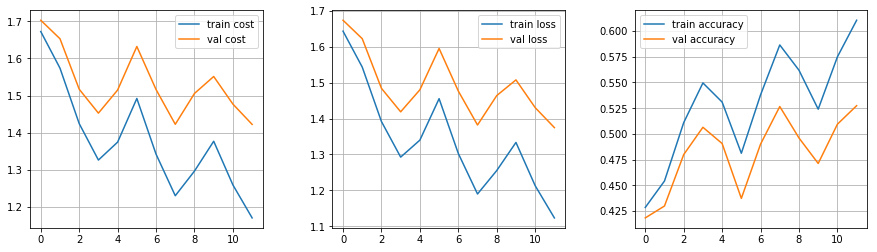

Train set accuracy: 0.6105555555555555
Validation set accuracy: 0.5274
Test set accuracy: 0.5157


In [117]:
# Save a dictionary into a pickle file.
import pickle


#pickle.dump( nn, open( "Networks/NN_data_augment_12ep.p", "wb" ) )

nn = pickle.load( open( "Networks/NN_data_augment_12ep.p", "rb" ) )

nn.plot_training()
print("Train set accuracy:",nn.accuracy(X,Y))
print("Validation set accuracy:",nn.accuracy(X_val,Y_val))
print("Test set accuracy:",nn.accuracy(X_test,Y_test_hot))

## 6) Ensamble of networks converged in local minimas

Epoch 44
Train accuracy: 0.6889111111111111 Train loss: 0.9105
Val accuracy: 0.5192 Val loss: 1.4457 



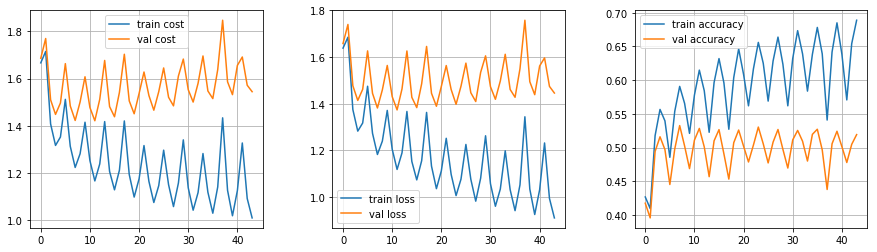

Save NN for ensamble in epoch: 44



In [161]:
Parameters
n_in, n = X.shape
n_out = 10
n_hidden = 50
n_s = 900
n_batch=100

cycle = int(2*n_s*n_batch/n)
n_epochs = cycle * 11

# Ensamble
ensamble_list = [3*cycle, 5*cycle, 7*cycle, 9*cycle,11*cycle]

# Network
nn = Network()
nn.add(Dense(n_in, n_hidden))
nn.add(ReLU())
nn.add(Dense(n_hidden, n_out))


# Train
nn.train(X, Y, X_val, Y_val, 
         shufle = True, n_epochs=n_epochs, eta=0.001, reg = 0.000470, visualize=True, 
         eta_min=1e-5, eta_max=1e-1,n_s=900, augment = False, ensamble_list=ensamble_list)



In [6]:
# Parameters
n_in, n = X.shape
n_s = 900
n_batch=100

cycle = int(2*n_s*n_batch/n)
n_epochs = cycle * 11

# Ensamble
ensamble_list = [3*cycle, 5*cycle, 7*cycle, 9*cycle,11*cycle]

import pickle
nns = []
for i in range(len(ensamble_list)):
    nns.append(pickle.load( open( "Networks/ensamble"+str(ensamble_list[i])+".p", "rb" ) ))

    print("Train set accuracy:",nns[i].accuracy(X,Y))
    print("Validation set accuracy:",nns[i].accuracy(X_val,Y_val))
    print("Test set accuracy:",nns[i].accuracy(X_test,Y_test_hot))
    print()
print("=================COMBINED: ============================")
print("Train set accuracy:",ensamble_prediction(nns,X,Y))
print("Validation set accuracy:",ensamble_prediction(nns,X_val,Y_val))
print("Test set accuracy:",ensamble_prediction(nns,X_test,Y_test_hot))

Train set accuracy: 0.6148888888888889
Validation set accuracy: 0.5284
Test set accuracy: 0.5113

Train set accuracy: 0.6465555555555556
Validation set accuracy: 0.526
Test set accuracy: 0.5087

Train set accuracy: 0.6638888888888889
Validation set accuracy: 0.5268
Test set accuracy: 0.5065

Train set accuracy: 0.6782444444444444
Validation set accuracy: 0.5272
Test set accuracy: 0.5097

Train set accuracy: 0.6889111111111111
Validation set accuracy: 0.5192
Test set accuracy: 0.5106

=================COMBINED: ============================
Train set accuracy: 0.6706444444444445
Validation set accuracy: 0.5318
Test set accuracy: 0.5126


## 7) Boosting (not much improvement)

Epoch 80
Train accuracy: 0.5367777777777778 Train loss: 1.4084
Val accuracy: 0.4636 Val loss: 1.5528 



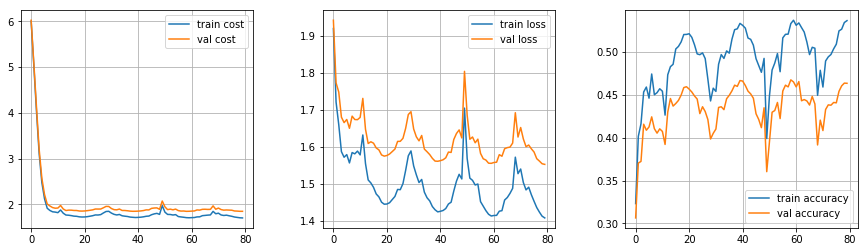

In [195]:
Parameters
n_in, n = X.shape
n_out = 10
n_hidden = 100

n_s = 900
n_batch=100
n_epochs = int(2*n_s*n_batch/n) * 11


## Network
nn = Network()
nn.add(Dense(n_in, n_hidden))
nn.add(ReLU())
nn.add(Dense(n_hidden, n_out))

n_i=int(n/5)
n_epochs = int(2*n_s*n_batch/n_i) * 4
# Train
for i in range(5):
    nn.train(X[:,i*n_i:(i+1)*n_i], Y[:,i*n_i:(i+1)*n_i], X_val, Y_val, 
             shufle = True, n_epochs=n_epochs, eta=0.001, reg = 0.04, visualize=True, 
             eta_min=1e-5, eta_max=1e-1,n_s=900, augment = True)
    pickle.dump(nn, open("Networks/boosting"+str(i+1)+".p", "wb"))



In [59]:
nns = []
for i in range(5):
    try:
        nns.append(pickle.load(  open("Networks/boosting"+str(i+1)+".p", "rb") ))
    except:
        pass
    print("Train set accuracy:",nns[i].accuracy(X,Y))
    print("Validation set accuracy:",nns[i].accuracy(X_val,Y_val))
    print("Test set accuracy:",nns[i].accuracy(X_test,Y_test_hot))
    print()
    
print("==============COMBINDED:=============================")
# Evaluate
print("Train set accuracy:",ensamble_prediction(nns,X,Y))
print("Validation set accuracy:",ensamble_prediction(nns,X_val,Y_val))
print("Test set accuracy:",ensamble_prediction(nns,X_test,Y_test_hot))

Train set accuracy: 0.47275555555555554
Validation set accuracy: 0.462
Test set accuracy: 0.4606

Train set accuracy: 0.47153333333333336
Validation set accuracy: 0.4688
Test set accuracy: 0.4634

Train set accuracy: 0.4706
Validation set accuracy: 0.4598
Test set accuracy: 0.4578

Train set accuracy: 0.4690888888888889
Validation set accuracy: 0.462
Test set accuracy: 0.4591

Train set accuracy: 0.47346666666666665
Validation set accuracy: 0.4636
Test set accuracy: 0.4648

==============COMBINDED:=============================
Train set accuracy: 0.48284444444444446
Validation set accuracy: 0.4712
Test set accuracy: 0.4725


## *) ALL IMPROVEMENTS COMBINED

Epoch 44
Train accuracy: 0.5759777777777778 Train loss: 1.2436
Val accuracy: 0.5408 Val loss: 1.3485 



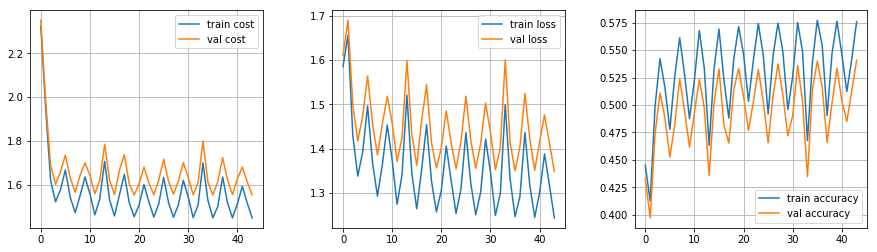

Save NN for ensamble in epoch: 44



In [6]:
import pickle
# Parameters
n_in, n = X.shape
n_out = 10
n_hidden = 100
n_s = 900
n_batch=100

cycle = int(2*n_s*n_batch/n)
n_epochs = cycle * 11

# Ensamble
ensamble_list = [3*cycle, 5*cycle, 7*cycle, 9*cycle,11*cycle]
# ensamble_name = "final_ensamble_"
ensamble_name = "final_ensamble_lambda_" #lambda=0.001
ensamble_name = "final_ensamble_lambda2_" #lambda=0.006
ensamble_name = "final_ensamble_lambda3_" #lambda=0.01
# Network
nn = Network()
nn.add(Dense(n_in, n_hidden))
nn.add(ReLU())
nn.add(Dense(n_hidden, n_out))


# Train
nn.train(X, Y, X_val, Y_val, 
         shufle = True, n_epochs=n_epochs, eta=0.001, reg = 0.01, visualize=True, 
         eta_min=1e-5, eta_max=1e-1, n_s=900, augment=True, ensamble_list=ensamble_list,
         ensamble_name=ensamble_name)



In [10]:
import pickle
## Ensamble names
# ensamble_name = "final_ensamble_"
# ensamble_name = "final_ensamble_lambda_"
#ensamble_name = "final_ensamble_lambda2_"
ensamble_name = "final_ensamble_lambda3_" #lambda=0.03
nns = []
for i in range(len(ensamble_list)):
    try:
        nns.append(pickle.load( open( "Networks/"+ensamble_name+str(ensamble_list[i])+".p", "rb" ) ))
    except:
        pass
    print("Train set accuracy:",nns[i].accuracy(X,Y))
    print("Validation set accuracy:",nns[i].accuracy(X_val,Y_val))
    print("Test set accuracy:",nns[i].accuracy(X_test,Y_test_hot))
    print()
    
print("=======================================================")
print("Train set accuracy:",ensamble_prediction(nns,X,Y))
print("Validation set accuracy:",ensamble_prediction(nns,X_val,Y_val))
print("Test set accuracy:",ensamble_prediction(nns,X_test,Y_test_hot))

Train set accuracy: 0.5678444444444445
Validation set accuracy: 0.5232
Test set accuracy: 0.531

Train set accuracy: 0.5714
Validation set accuracy: 0.5332
Test set accuracy: 0.5337

Train set accuracy: 0.5746
Validation set accuracy: 0.5374
Test set accuracy: 0.5293

Train set accuracy: 0.5772
Validation set accuracy: 0.54
Test set accuracy: 0.5323

Train set accuracy: 0.5759777777777778
Validation set accuracy: 0.5408
Test set accuracy: 0.5316

Train set accuracy: 0.5775333333333333
Validation set accuracy: 0.54
Test set accuracy: 0.5357


# 8) Better cyclical learning rate parameters for other models

In [2]:
X,Y=load_all_and_preproc()
Y = one_hot(10,Y)
X, Y, X_val, Y_val = create_val_set(X,Y)

print(X.shape,Y.shape, X_val.shape, Y_val.shape)


# Test
X_test,Y_test,filenames_test = LoadBatch('test_batch')
Y_test_hot = one_hot(10,Y_test)
X_test=preprocess(X_test)

(3072, 45000) (10, 45000) (3072, 5000) (10, 5000)


### LR TEST

Epoch 7
Train accuracy: 0.36473333333333335 




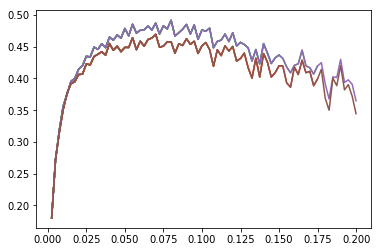

In [49]:
# Parameters
n_in, n = X.shape
n_out = 10
n_hidden = 100
n_batch=100
n_s = n/n_batch * 2#900 like suggested in the papper, could use 3,4,5 instead of 2 too.

n_epochs = 8
n_s = int(n_epochs*n/n_batch) #

## Network
nn = Network()
nn.add(Dense(n_in, n_hidden))
nn.add(ReLU())
nn.add(Dense(n_hidden, n_out))

# Etas to do LR range test

# Train
nn.train(X, Y, X_val, Y_val, shufle = False, n_epochs=n_epochs,
         eta=0.001, reg=0.01, visualize=True, augment = False,
         eta_min=0.00001, eta_max=0.2, n_s=n_s)






In [ ]:
import pickle
#pickle.dump(nn, open("Networks/L_R_test.p", "wb"))
nn = pickle.load(open("Networks/L_R_test.p", "rb"))

Text(0.5,1,'LR Test')

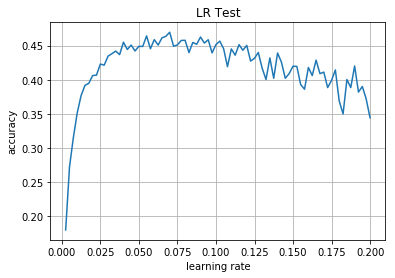

In [61]:
#plt.plot(nn.eta_loglog,nn.train_acc_log,label='train accuracy')
plt.plot(nn.eta_loglog,nn.val_acc_log,label='validation accuracy')
plt.grid()
plt.xlabel("learning rate")
plt.ylabel("accuracy")
plt.title("LR Test")